## Phi4 Multimodal Instruct 

* From Microsoft Research
* Ranked #51 in OpenCompass multimodal academic leaderboard (https://rank.opencompass.org.cn/leaderboard-multimodal)

* It doesn't work well in object detection

In [1]:
import sys
import os
from transformers import AutoModel, AutoProcessor
import torch

# Add the desired directory to the Python path
sys.path.append(os.path.abspath('/data/students/earl/llava-dissector/Phi-4-multimodal-instruct'))

import urllib
from io import BytesIO
from PIL import Image

device = "cuda:5"

model_path = '/data/students/earl/llava-dissector/Phi-4-multimodal-instruct'
model = AutoModel.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True).eval().to(device)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

# Add <|image|> special token if missing
if "<|image|>" not in processor.tokenizer.additional_special_tokens:
    processor.tokenizer.add_special_tokens({'additional_special_tokens': ["<|image|>"]})
    model.resize_token_embeddings(len(processor.tokenizer))

/data/students/earl/anaconda3/envs/deepseek/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/students/earl/anaconda3/envs/deepseek/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
/data/students/earl/.cache/huggingface/modules/transformers_modules/Phi-4-multimodal-instruct/speech_conformer_encoder.py:2774: FutureWarning: Please specify CheckpointImpl.NO_REENTRANT as CheckpointImpl.REENTRANT will soon be rem

## Extract the object and visualize

  [[0.34, 0.38, 0.51, 0.63], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.58, 0.41, 0.76], [0.29, 0.

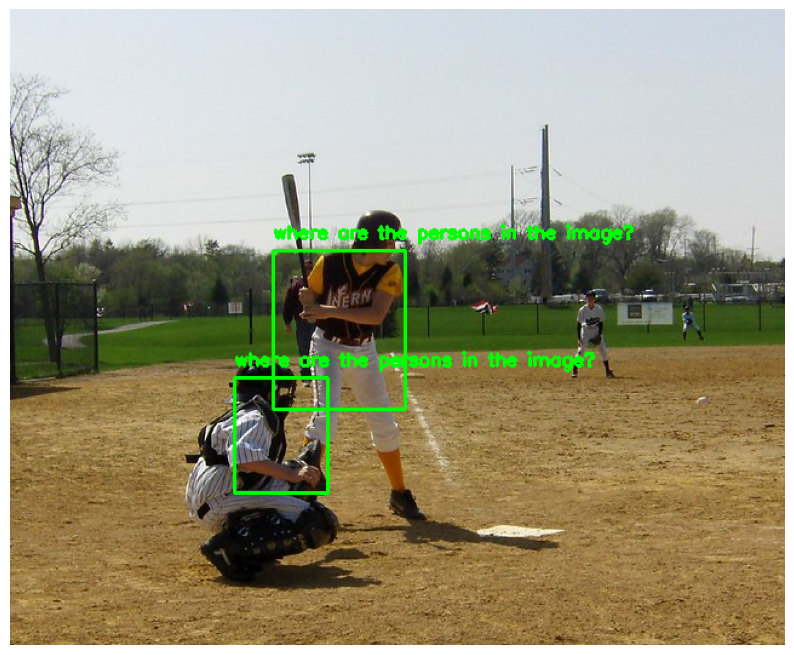

In [8]:
cls = "where are the persons in the image?"


url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg"
img = urllib.request.urlopen(url=url, timeout=5).read()
img = Image.open(BytesIO(img)).convert("RGB")

prompt = (
    "You are Phi-4, a large multimodal model. "
    #"You provide the bounding box coordinates of all instances of an object class when asked. "
    #"The format of the bounding box coordinates is [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]. "
    " <|image_1|> " #" <|endoftext10|>"#"<|image|> "
    f"Give the normalized bounding box coordinates of all instances of {cls} in the image."
    #f"Provide the bounding box coordinates of {cls}"
)
res = processor(
    text=[prompt],   # or text=prompt
    images=[img]
)

with torch.inference_mode():
    model.to(dtype=torch.float16, device=device)
    output_ids = model.generate(
        input_ids=res["input_ids"].to(device),
        input_image_embeds=res["input_image_embeds"].to(dtype=torch.float16, device=device),
        image_attention_mask=res["image_attention_mask"].to(device),
        image_sizes=res["image_sizes"],
        attention_mask=res["attention_mask"].to(device),
        input_mode=res["input_mode"],  # <-- Add this line
        do_sample=False,
        max_new_tokens=1024,
        repetition_penalty=1.0,
        return_dict_in_generate=True,
        output_scores=True,
    )
input_token_len = res["input_ids"].shape[1]
generation_text = processor.batch_decode(output_ids.sequences[:, input_token_len:])[0]
generation_text = generation_text.replace("<|im_end|>", "")
print(generation_text)

## Visualize using cv2

# Extract the bounding box coordinates from the output
# Make sure the list is a list of floats
# Example output: "Bounding box coordinates: [[x1, y1, x2, y2], [x1, y1, x2, y2]]"
import re
import matplotlib.pyplot as plt

pattern = r'\[\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*\]'
matches = re.findall(pattern, generation_text)
bounding_boxes = [[float(coord) for coord in match] for match in matches]
print("Bounding boxes:", bounding_boxes)

# Visualize using cv2
import cv2
import numpy as np
img_cv = np.array(img)
for box in bounding_boxes:
    x1, y1, x2, y2 = box
    # convert these normalized coordinates to pixel values
    h, w, _ = img_cv.shape
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 
